<a href="https://colab.research.google.com/github/Anthei0774/Cash_n_Guns/blob/main/Game_Simulator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pandasql

# Setup and defnitions

In [ ]:
import random
from math import exp

import numpy as np
import pandas as pd
import datetime as dt
from pandasql import sqldf 
from scipy.stats import ttest_ind

import os, shutil
path = "drive/MyDrive/Egyetem/5th semester/Thesis work/Results/"

####################################################################################################

cards = []

# adding cash, diamonds, paintings
cards += ["C5"] * 15 + ["C10"] * 15 + ["C20"] * 10
cards += ["D1"] * 5 + ["D5"] * 3 + ["D10"]
cards += ["P"] * 10

# adding bangs and first aid
cards += ["B"] * 3
cards += ["FA"] * 2

painting_map = {
    0 : 0,
    1 : 4,
    2 : 12,
    3 : 30,
    4 : 60,
    5 : 100,
    6 : 150,
    7 : 200,
    8 : 300,
    9 : 400,
    10 : 500
}

def get_stats(df_h):
    stats = df_h.describe()
    stats = stats.round(4)
    stats = stats.reset_index()
    stats = stats[ stats["index"].isin(["mean", "std", "min", "50%", "max"]) ]
    stats = stats.rename(columns = {"index" : None })
    stats.index = stats[None]
    del stats[None]
    stats.index = ["mean", "std", "min", "med", "max"]
    return stats

In [ ]:
from itertools import permutations

priority_list = ["D10", "D5", "D1", "C20", "C10", "C5", "P"]
# priority_list += ["G", "FA", "B"]

raw_grid = list(permutations(priority_list))
print(f"Raw grid lenght: {len(raw_grid)}")

looting_grid = []
for g in raw_grid:
    
    valid = True

    d1 = g.index("D1")
    d5 = g.index("D5")
    d10 = g.index("D10")
    if d1 < d5 or d1 < d10 or d5 < d10:
        valid = False

    c5 = g.index("C5")
    c10 = g.index("C10")
    c20 = g.index("C20")
    if c5 < c10 or c5 < c20 or c10 < c20:
        valid = False

    if c10 < d10 or c5 < d5 or c5 < d1:
        valid = False

    p = g.index("P")
    if c5 < p or p < c20:
        valid = False

    if valid:
        new_g = list(g)
        new_g = new_g[:4] + ["G"] + new_g[4:]
        looting_grid.append(new_g)

looting_grid = { i : {"priority" : g} for i, g in enumerate(looting_grid) }
print(f"Final grid lenght: {len(looting_grid)}")

looting_grid = pd.DataFrame(looting_grid)
looting_grid = looting_grid.transpose()
looting_grid

Raw grid lenght: 5040
Final grid lenght: 35


,priority
0,"[D10, D5, D1, C20, G, C10, P, C5]"
1,"[D10, D5, D1, C20, G, P, C10, C5]"
2,"[D10, D5, C20, D1, G, C10, P, C5]"
3,"[D10, D5, C20, D1, G, P, C10, C5]"
4,"[D10, D5, C20, C10, G, D1, P, C5]"
5,"[D10, D5, C20, C10, G, P, D1, C5]"
6,"[D10, D5, C20, P, G, D1, C10, C5]"
7,"[D10, D5, C20, P, G, C10, D1, C5]"
8,"[D10, C20, D5, D1, G, C10, P, C5]"
9,"[D10, C20, D5, D1, G, P, C10, C5]"


In [ ]:
class Player():

    def __init__(self, index, behavior):

        # set index for ease of reference
        self.index = index
        
        # set lay down behavior : random, heuristic, genetic
        self.laydown_behavior = behavior["laydown"] 
        
        # set looting behavior : random or from the refined grid
        global looting_grid

        # heuristic priority : choosing one from the looting grid
        # TO BE REFINED FOR THE BEST
        self.loot_behavior = behavior["looting"] 
        if self.loot_behavior == "heuristic":
            self.loot_index = random.randint(0, len(looting_grid) - 1)
            self.priority = looting_grid["priority"][self.loot_index].copy()

        # health, bullets and other variables
        self.alive = True
        self.wounds = 0
        self.bangs = 3
        self.clips = 5
        self.is_injured = False
        self.loot = []
        self.bonus = False
        self.total = 0

    ################################################################################################

    def choose_target_bullet(self, opps):

        # set to null at start
        self.target = None
        self.bullet = ''

        # if there is at least one opponent
        if len(opps) != 0:

            # select an opponent randomly
            self.target = random.choice(opps)

            # select a bang / clip randomly weighted
            p = self.bangs / (self.bangs + self.clips)
            if  random.random() < p:
                self.bullet = "B"
            else:
                self.bullet = "C"

            # decrease number of bullets
            if self.bullet == "B":
                self.bangs -= 1
            else:
                self.clips -= 1

    ################################################################################################
    
    def stand_off_decide(self, round, opps):

        global heuristic_laydown

        if self.laydown_behavior == "random":
            if opps == 0:
                p = 0
            else:
                p = 0.5

        if self.laydown_behavior == "heuristic":
            # if random.random() < heuristic_laydown["eps"]:
                # p = 0.5
            # else:
            p = heuristic_laydown[opps]
        
        self.is_coward = (random.random() < p)

        # record number of opponents for history
        self.opps = opps

    ################################################################################################
    
    def take_damage(self):
        self.wounds += 1
        self.is_injured = True
        self.alive = (self.wounds < 3)
    
    ################################################################################################

    ### taking loot from the remaining pile
    def take_loot(self, loot_left, round):

        # init loot taken
        l = None

        # random loot take
        if self.loot_behavior == "random":
            l = random.choice(loot_left)

        # any heuristic loot take
        else:
            
            # if ending game, remove middle Godfather, push utils to the end
            if round == 8:
                self.priority.remove("G")
                self.priority += ["G", "FA", "B"]

            # else in mid game, leave godfather preference mid
            else:

                # if seriously wounded, take First Aid
                if self.wounds == 2:
                    self.priority = ["FA"] + self.priority + ["B"]
                else:
                    # if out of bangs, set it priority
                    if self.bangs == 0:
                        self.priority = ["B"] + self.priority + ["FA"]
                    else:
                        self.priority += ["B", "FA"]

                # priority list is complete: no missing, no redundant
                # assert sorted(self.priority) == ['B', 'C10', 'C20', 'C5', 'D1', 'D10', 'D5', 'FA', 'G', 'P'], print(sorted(self.priority))

            # search for card
            for p in self.priority:
                if p in loot_left:
                    l = p
                    break

        # apply effect
        if l == "FA":
            self.wounds = 0
        if l == "B" and self.clips != 0:
            self.bangs += 1
            self.clips -= 1
        if l not in ["FA", "B", "G"]:
            self.loot.append(l)

        
        # restoring priority
        if self.loot_behavior != "random":
            self.priority.remove("FA")
            self.priority.remove("B")
            self.priority.remove("G")
            self.priority = self.priority[:4] + ["G"] + self.priority[4:]

        # return picked card to remove it from the pile
        return l

    ################################################################################################

    # reset status at the end of the turn
    def stats_reset(self):
        self.is_coward = False
        self.is_injured = False

    ################################################################################################

    # print status for verbosity
    def print_status(self):
        return f": wounds {self.wounds}, bangs {self.bangs}, clips {self.clips}, loot {self.loot}"

    ################################################################################################

    def calc_loot(self):

        # add diamond bonus
        if self.bonus:
            self.total += 60

        # add paintings total
        n_paints = self.loot.count("P")
        self.total += painting_map[n_paints]

        values = [ int(l[ 1: ]) for l in self.loot if l[0] != "P" ]
        self.total += sum(values)

In [ ]:
class Game():    

    # init game
    def __init__(self, behavior_list, verbose = False):

        self.round = 0

        # shuffle cards
        global cards
        random.shuffle(cards)
        self.cards_in_deck = cards.copy()

        # init players
        self.players = [ Player(i, behavior_list[i]) for i in range(8) ]
        self.godfather = random.choice(self.players)

        # verbosity
        self.verbose = verbose

    ################################################################################################

    # put 8 cards on the table
    def dealing_cards(self):

        self.round += 1

        self.cards_on_table = self.cards_in_deck[ : 8 ]
        self.cards_in_deck = self.cards_in_deck[ 8 : ]

        if self.verbose:
            print(f"--- Round { self.round } ---")
            print(f"Cards on table: { self.cards_on_table }")
            print(f"Godfather: { self.godfather.index }")

    ################################################################################################

    def hold_up(self):

        # for each player still in the game
        for p in self.players:
            if p.alive:

                # select all possible opponents ( != self ), target one randomly
                opps = [ o for o in self.players if o.alive and p != o ]
                p.choose_target_bullet(opps)

            if self.verbose:
                print(f"{ p.index } targets { p.target.index } with { p.bullet }")

    ################################################################################################

    def godfathers_privilage(self):

        # if the godfather has an enemy
        if len(self.godfather.opps) != 0:

            # chose one enemy, force to target next
            p = random.choice(self.godfather.opps)
            i = (self.godfather.index + 1) % 8

            # search for next until finding one alive or looping back
            while not self.players[i].alive and i != self.godfather.index:
                i = (i + 1) % 8

            if i != self.godfather.index:
                p.target = self.players[i]
                if self.verbose: print(f"Player {i} forced to target {p.target}")

    ################################################################################################

    def stand_off(self):

        # init players who participate in the stand-off
        self.players_shooting = []

        # count the number of players alive
        n_alive = sum([ p.alive for p in self.players ])

        # if there are more than one alive
        if n_alive > 1:

            # for each alive player
            for p in self.players:
                if p.alive:

                    # calculate the number of opponents who target this player
                    n_opps = sum([ p.index == o.target.index for o in self.players if o.alive and p != 0 ])

                    # decide whether it is worth to participate
                    p.stand_off_decide(self.round, n_opps)

                    if not p.is_coward: self.players_shooting.append(p)
                    decision = "lays down" if p.is_coward else "stays up"
                    if self.verbose: print(f'{ p.index } {decision}')

        # if there is only one player standing
        else:
            self.players_shooting = [ p for p in self.players if p.alive ]

                
    ################################################################################################

    # see the outcome of the stand-off
    def banzai(self):

        # for each shooting player
        for p in self.players_shooting:
            if p.target != None:
                if p.bullet == "B" and not p.target.is_coward:

                    # inflict damage and set injuries
                    p.target.take_damage()

        # collect all uninjured players
        self.players_looting = [ p for p in self.players_shooting if not p.is_injured ]

        if self.verbose:
            for p in self.players_shooting:
                if p not in self.players_looting:
                    status = 'but stays alive' if p.alive else 'and dies'
                    print(f'{ p.index } gets injured {status}')

    ################################################################################################

    def loot_share(self):

        # saving indices for verbosity
        indices = [ p.index for p in self.players_looting ]

        # add godfather card to the loot
        self.cards_on_table.append('G')

        # if there is a player who can loot
        if len(self.players_looting) != 0:

            # find starting player  
            p = self.godfather
            while p not in self.players_looting:
                i = p.index + 1 if p.index + 1 < 8 else 0
                p = self.players[i]

            if self.verbose: print(f'Looters: { indices }, { p.index } starts looting')

            # while there is a card on the table
            while len(self.cards_on_table) != 0:

                # take loot
                l = p.take_loot(self.cards_on_table, self.round)
                self.cards_on_table.remove(l)
                if self.verbose: print(f'{ p.index } picks {l}')

                if l == 'G':
                    self.godfather = p

                # move the index to next player looting
                i = self.players_looting.index(p)
                p = self.players_looting[i + 1] if i + 1 < len(self.players_looting) else self.players_looting[0]

        else:
            if self.verbose: print('Nobody claims this turn\'s loot')

    ################################################################################################

    # reset game state after a round
    def reset(self):

        for p in self.players:
            p.stats_reset()
        
            if self.verbose:
                status = 'alive' if p.alive else 'dead'
                print( f'{ p.index } is { status }' + p.print_status() )

    ################################################################################################

    def game_ends(self, verbose = False):

        if self.verbose: print('The game ends')

        # find the players with diamonds
        diamonds = {}

        # also keep track of owner of max amount
        M = 0
        for p in self.players:
            if p.alive:

                # see if player has diamonds
                m = len([ l for l in p.loot if l[0] == 'D' ])
                if 0 < m:
                    if m not in diamonds:
                        diamonds[m] = [p]
                    else:
                        diamonds[m].append(p)
                if M < m:
                    M = m

        # find the player having the most diamonds
        if M != 0:
            if len(diamonds[M]) == 1:
                p = diamonds[M][0]
                p.bonus = True
                if self.verbose: print(f'Player { p.index } gets the diamond bonus')
            else:
                if self.verbose: print('No one gets the diamond bonus')

        # find winner(s) of the game
        self.winners = []
        M = 0
        for p in self.players:
            if p.alive:

            # calculate player loot
                p.calc_loot()
                if self.verbose: print(f'Player { p.index } total loot : { p.total }')

                if M == p.total:
                    self.winners.append(p)
                if M < p.total:
                    self.winners = [p]
                    M = p.total
        
        if self.verbose: print(f'Player(s) { [ p.index for p in self.winners ] } win the game')

    ################################################################################################

    def play(self):

        good_decisions = 0
        participations = 0
        d = {}

        p = self.players[0]

        for i in range(8):

            # 1st part of the game, key decisions made, survival calculated
            self.dealing_cards()
            self.hold_up()
            # self.godfathers_privilage()
            self.stand_off()
            self.banzai()

            # save good decisions
            if not self.verbose:
                if p.alive:
                    # player laid down and ...
                    if p.is_coward:
                        # if she was targeted by at least one bangs then it was a good (True), else a bad (False) decision
                        decision = any([ o.bullet == 'B' for o in self.players_shooting if p.index == o.target.index])
                    # player stayed up and...
                    else:
                        # was targeted with only clips, then it was a good, else a bad decision
                        decision = all([ o.bullet == 'C' for o in self.players_shooting if p != o and p.index == o.target.index])

                    good_decisions += int(decision)

                    d["opps"] = p.opps
                    if decision:
                        d["laid"] = p.is_coward
                    # else:
                        # d["laid"] = not p.is_coward
            
            ### share loot and reset all stats
            if p in self.players_looting:
                participations += 1

            self.loot_share()
            self.reset()
            
        # end game
        self.game_ends()

        if not self.verbose:
            h = {}
            h["n_dec"] = good_decisions
            h["n_wou"] = p.wounds
            h["sur_r"] = int(p.alive)
            h["net_w"] = p.total
            h["win_r"] = int(p in self.winners)
            h["n_pai"] = p.loot.count("P")
            h["n_dia"] = sum([ 1 for i in p.loot if i[0] == "D" ])
            h["dia_b"] = int(p.bonus)
            h["n_par"] = participations
            h["l_ind"] = p.loot_index if p.loot_behavior == "heuristic" else None

            return h, d

        else:
            return None

In [ ]:
def simulator(
    behavior_list,
    n_games = 10000,
    step = 20
    ):

    verbose = (n_games in [1, 2, 3]) # only showing for small number of games

    history = []
    decision = []

    progress = 0
    for n in range(n_games):

        g = Game(behavior_list, verbose)
        h, d = g.play()
        history.append(h)
        decision.append(d)

        if not verbose:
            if progress + step < round(n / n_games * 100):
                progress += step
                print(f"{progress}%")

    return history, decision

# Simulation

### random

In [ ]:
# setup = [ {"laydown" : "random", "looting" : "random"} for i in range(8)]
# history, decision = simulator(setup)
# df_h = pd.DataFrame(history)
# df_d = pd.DataFrame(decision)

In [ ]:
# df_h

In [ ]:
# stats = get_stats(df_h)
# stats

In [ ]:
# from matplotlib import pyplot as plt

# s = 4
# plt.figure(figsize = (6.4 * s, 4.8 * s))
# legends = True

# ####################################################################################################

# plt.subplot(3, 2, 1)
# ax_n_dec = df_h.n_dec.hist(bins = 9 * 4, legend = legends)
# ax_n_dec.set_xlim(0, 8)
# ax_n_dec.legend(loc = 2, prop = { "size" : 25})

# plt.subplot(3, 2, 2)
# ax_n_wou = df_h.n_wou.hist(bins = 6 * 4, legend = legends)
# ax_n_wou.set_xlim(0, 5)
# ax_n_wou.legend(loc = 1, prop = { "size" : 25})

# plt.subplot(3, 2, 3)
# ax_net_w = df_h.net_w.hist(bins = 25 * 4, legend = legends)
# ax_net_w.set_xlim(0, 250)
# ax_net_w.legend(loc = 1, prop = { "size" : 25})

# plt.subplot(3, 2, 4)
# ax_n_pai = df_h.n_pai.hist(bins = 11 * 4, legend = legends)
# ax_n_pai.set_xlim(0, 10)
# ax_n_pai.legend(loc = 1, prop = { "size" : 25})

# plt.subplot(3, 2, 5)
# ax_n_dia = df_h.n_dia.hist(bins = 10 * 4, legend = legends)
# ax_n_dia.set_xlim(0, 9)
# ax_n_dia.legend(loc = 1, prop = { "size" : 25})

# plt.subplot(3, 2, 6)
# ax_n_par = df_h.n_par.hist(bins = 9 * 4, legend = legends)
# ax_n_par.set_xlim(0, 8)
# ax_n_par.legend(loc = 1, prop = { "size" : 25})

In [ ]:
# corr = df_h.corr().round(4)
# corr

### heuristic

In [ ]:
aggregate = True

strategy_mat = {i : [0.5 if i != 0 else 0] for i in range(8)}
strategy_mat["w"] = [0.125]
strategy_mat["d"] = [5.2]
heuristic_laydown = { i : strategy_mat[i][0] for i in strategy_mat }
strategy_mat = pd.DataFrame(strategy_mat)

# strategy_mat = pd.DataFrame({i : [round(i / 7, 4)] for i in range(8)})
# heuristic_laydown = { i : round(i / 7, 4) for i in range(8)}

i = 0
while i < 25:

    print(i, heuristic_laydown)

    setup = [ {"laydown" : "heuristic", "looting" : "random"} ] + [ {"laydown" : "random", "looting" : "random"} for i in range(7)]
    history, decision = simulator(setup)
    df_h = pd.DataFrame(history)
    df_d = pd.DataFrame(decision)

    tmp = df_h.describe()
    w = tmp.loc[tmp.index == "mean", "win_r"].values[0]
    d = tmp.loc[tmp.index == "mean", "n_dec"].values[0]
    print("win_rate", w, "mean decisions", d)

    tmp = sqldf("""select opps as o, round(avg(laid), 4) as p from df_d group by o""")
    tmp = list(tmp.p.values)
    tmp = { i - 1 : [round(v, 4)] for i, v in enumerate(tmp) if i > 0}
    for j in range(8):
        if j <= 2:
            assert j in tmp
        else:
            if j not in tmp:
                tmp[j] = [ round(tmp[j - 1][0] / 2 + 0.5, 4) ]
    tmp["w"] = [w]
    tmp["d"] = [d]

    tmp = pd.DataFrame(tmp)
    strategy_mat = pd.concat([strategy_mat, tmp])

    if aggregate:
        tmp = strategy_mat.describe().round(4)
        tmp = tmp[tmp.index == "mean"]
        tmp = list(tmp.values[0])
        tmp = {i : tmp[i] for i in range(8)}
    else:
        tmp = tmp.to_dict()
        tmp = {i : tmp[i][0] for i in tmp}

    heuristic_laydown = tmp
    # heuristic_laydown["eps"] = round(1 / (i + 1) * 0.1, 4)

    i += 1

0 {0: 0, 1: 0.5, 2: 0.5, 3: 0.5, 4: 0.5, 5: 0.5, 6: 0.5, 7: 0.5, 'w': 0.125, 'd': 5.2}
20%
40%
60%
80%
win_rate 0.1191 mean decisions 5.2176
1 {0: 0.0, 1: 0.3717, 2: 0.4386, 3: 0.4704, 4: 0.497, 5: 0.25, 6: 0.75, 7: 0.75}
20%
40%
60%
80%
win_rate 0.1531 mean decisions 5.3664
2 {0: 0.0, 1: 0.3053, 2: 0.3912, 3: 0.4528, 4: 0.4912, 5: 0.2222, 6: 0.6945, 7: 0.7639}
20%
40%
60%
80%
win_rate 0.184 mean decisions 5.4358
3 {0: 0.0, 1: 0.2669, 2: 0.3648, 3: 0.4389, 4: 0.4918, 5: 0.2084, 6: 0.6667, 7: 0.7708}
20%
40%
60%
80%
win_rate 0.1947 mean decisions 5.4559
4 {0: 0.0, 1: 0.2384, 2: 0.3418, 3: 0.4253, 4: 0.4973, 5: 0.2556, 6: 0.6778, 7: 0.7889}
20%
40%
60%
80%
win_rate 0.2046 mean decisions 5.4982
5 {0: 0.0, 1: 0.2185, 2: 0.3255, 3: 0.4172, 4: 0.4908, 5: 0.2546, 6: 0.669, 7: 0.7928}
20%
40%
60%
80%
win_rate 0.2129 mean decisions 5.4916
6 {0: 0.0, 1: 0.2018, 2: 0.311, 3: 0.407, 4: 0.4921, 5: 0.2387, 6: 0.6551, 7: 0.7918}
20%
40%
60%
80%
win_rate 0.216 mean decisions 5.5012
7 {0: 0.0, 1: 0.189

In [ ]:
# stats = get_stats(strategy_mat)
# stats = stats[stats.index == "med"]
# stats
# # strategy_mat

In [ ]:
# s = 3
# plt.figure(figsize = (6.4 * s, 4.8 * s))
# legends = True

# ####################################################################################################

# plt.subplot(2, 2, 1)
# ax_n_dec = df_h.n_dec.hist(bins = 9 * 4, legend = legends)
# ax_n_dec.set_xlim(0, 8)
# ax_n_dec.legend(loc = 2, prop = { "size" : 25})

# plt.subplot(2, 2, 2)
# ax_n_wou = df_h.n_wou.hist(bins = 6 * 4, legend = legends)
# ax_n_wou.set_xlim(0, 5)
# ax_n_wou.legend(loc = 1, prop = { "size" : 25})

# plt.subplot(2, 2, 3)
# ax_net_w = df_h.net_w.hist(bins = 25 * 4, legend = legends)
# ax_net_w.set_xlim(0, 250)
# ax_net_w.legend(loc = 1, prop = { "size" : 25})

# plt.subplot(2, 2, 4)
# ax_n_par = df_h.n_par.hist(bins = 9 * 4, legend = legends)
# ax_n_par.set_xlim(0, 8)
# ax_n_par.legend(loc = 2, prop = { "size" : 25})

In [ ]:
# df_h.corr()

In [ ]:
setup = [ {"laydown" : "random", "looting" : "heuristic"} ] + [ {"laydown" : "random", "looting" : "random"} for i in range(7)]
history, decision = simulator(setup)
df_h = pd.DataFrame(history)
df_d = pd.DataFrame(decision)

get_stats(df_h)

20%
40%
60%
80%


,n_dec,n_wou,sur_r,net_w,win_r,n_pai,n_dia,dia_b,n_par,l_ind
mean,5.2214,1.0009,0.8972,103.0163,0.3904,1.2050,1.4596,0.1518,4.2539,16.9642
std,1.5453,1.0169,0.3037,59.3141,0.4879,1.2263,1.2888,0.3588,1.5449,10.1393
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
med,5.0000,1.0000,1.0000,103.0000,0.0000,1.0000,1.0000,0.0000,4.0000,17.0000
max,8.0000,5.0000,1.0000,392.0000,1.0000,7.0000,8.0000,1.0000,8.0000,34.0000


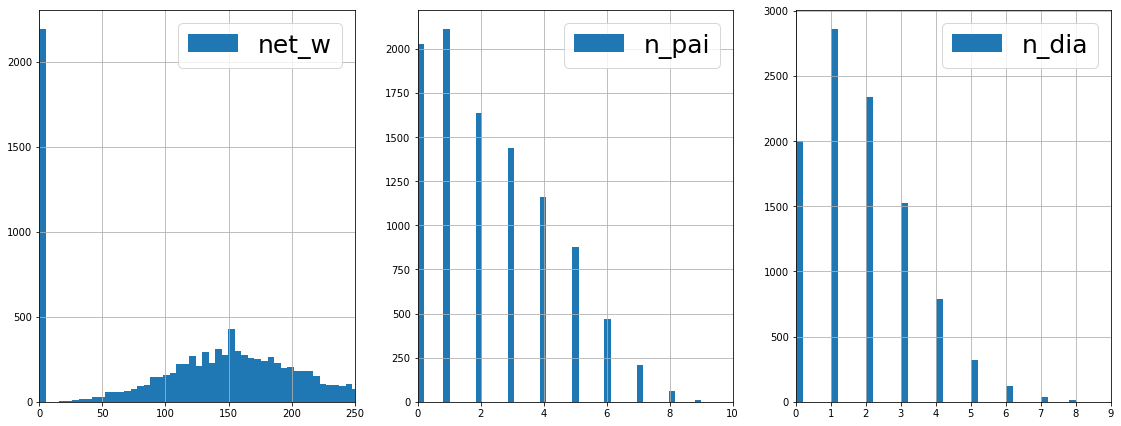

In [ ]:
s = 3
plt.figure(figsize = (6.4 * s, 4.8 * s / 2))
legends = True

####################################################################################################

plt.subplot(1, 3, 1)
ax_net_w = df_h.net_w.hist(bins = 25 * 4, legend = legends)
ax_net_w.set_xlim(0, 250)
ax_net_w.legend(loc = 1, prop = { "size" : 25})

plt.subplot(1, 3, 2)
ax_n_pai = df_h.n_pai.hist(bins = 11 * 4, legend = legends)
ax_n_pai.set_xlim(0, 10)
ax_n_pai.legend(loc = 1, prop = { "size" : 25})

plt.subplot(1, 3, 3)
ax_n_dia = df_h.n_dia.hist(bins = 10 * 4, legend = legends)
ax_n_dia.set_xlim(0, 9)
ax_n_dia.legend(loc = 1, prop = { "size" : 25})

In [ ]:
df_h.corr()

,n_dec,n_wou,sur_r,net_w,win_r,n_pai,n_dia,dia_b,n_par,l_ind
n_dec,1.000000,-0.600584,0.547686,0.681336,0.499860,0.330859,0.325558,0.210617,0.816143,0.006574
n_wou,-0.600584,1.000000,-0.702244,-0.512389,-0.308338,-0.195814,-0.188708,-0.138479,-0.481801,-0.011320
sur_r,0.547686,-0.702244,1.000000,0.540329,0.263434,0.182260,0.185629,0.138012,0.445592,0.008579
net_w,0.681336,-0.512389,0.540329,1.000000,0.733231,0.486022,0.383024,0.420438,0.810855,0.034618
win_r,0.499860,-0.308338,0.263434,0.733231,1.000000,0.334060,0.349076,0.389501,0.635935,-0.000222
n_pai,0.330859,-0.195814,0.182260,0.486022,0.334060,1.000000,0.004360,-0.009857,0.408027,0.337521
n_dia,0.325558,-0.188708,0.185629,0.383024,0.349076,0.004360,1.000000,0.720612,0.408564,-0.378041
dia_b,0.210617,-0.138479,0.138012,0.420438,0.389501,-0.009857,0.720612,1.000000,0.268908,-0.277309
n_par,0.816143,-0.481801,0.445592,0.810855,0.635935,0.408027,0.408564,0.268908,1.000000,0.004544
l_ind,0.006574,-0.011320,0.008579,0.034618,-0.000222,0.337521,-0.378041,-0.277309,0.004544,1.000000


In [ ]:
setup = [ {"laydown" : "heuristic", "looting" : "heuristic"} ] + [ {"laydown" : "random", "looting" : "random"} for i in range(7)]
history, decision = simulator(setup)
df_h = pd.DataFrame(history)
df_d = pd.DataFrame(decision)

get_stats(df_h)

20%
40%
60%
80%


,n_dec,n_wou,sur_r,net_w,win_r,n_pai,n_dia,dia_b,n_par,l_ind
mean,5.6026,1.4743,0.7768,129.0989,0.5864,2.3378,1.8052,0.2154,5.2507,26.3675
std,1.7653,1.1203,0.4164,89.1540,0.4925,1.9845,1.4713,0.4111,1.7439,15.7579
min,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0000
med,6.0000,1.0000,1.0000,140.0000,1.0000,2.0000,2.0000,0.0000,6.0000,27.0000
max,8.0000,5.0000,1.0000,595.0000,1.0000,10.0000,8.0000,1.0000,8.0000,53.0000


In [ ]:
df_h.corr()

,n_dec,n_wou,sur_r,net_w,win_r,n_pai,n_dia,dia_b,n_par,l_ind
n_dec,1.000000,-0.747138,0.747204,0.775392,0.661136,0.381701,0.406317,0.304410,0.944512,0.001206
n_wou,-0.747138,1.000000,-0.786428,-0.724463,-0.588241,-0.270946,-0.295919,-0.275908,-0.707129,-0.005558
sur_r,0.747204,-0.786428,1.000000,0.776240,0.638262,0.276049,0.298761,0.280861,0.704911,0.007640
net_w,0.775392,-0.724463,0.776240,1.000000,0.780576,0.530803,0.375913,0.426128,0.802699,0.062738
win_r,0.661136,-0.588241,0.638262,0.780576,1.000000,0.347305,0.369105,0.393610,0.692571,-0.002346
n_pai,0.381701,-0.270946,0.276049,0.530803,0.347305,1.000000,-0.000650,-0.005347,0.406415,0.360455
n_dia,0.406317,-0.295919,0.298761,0.375913,0.369105,-0.000650,1.000000,0.751075,0.433327,-0.427749
dia_b,0.304410,-0.275908,0.280861,0.426128,0.393610,-0.005347,0.751075,1.000000,0.319290,-0.317835
n_par,0.944512,-0.707129,0.704911,0.802699,0.692571,0.406415,0.433327,0.319290,1.000000,-0.003040
l_ind,0.001206,-0.005558,0.007640,0.062738,-0.002346,0.360455,-0.427749,-0.317835,-0.003040,1.000000


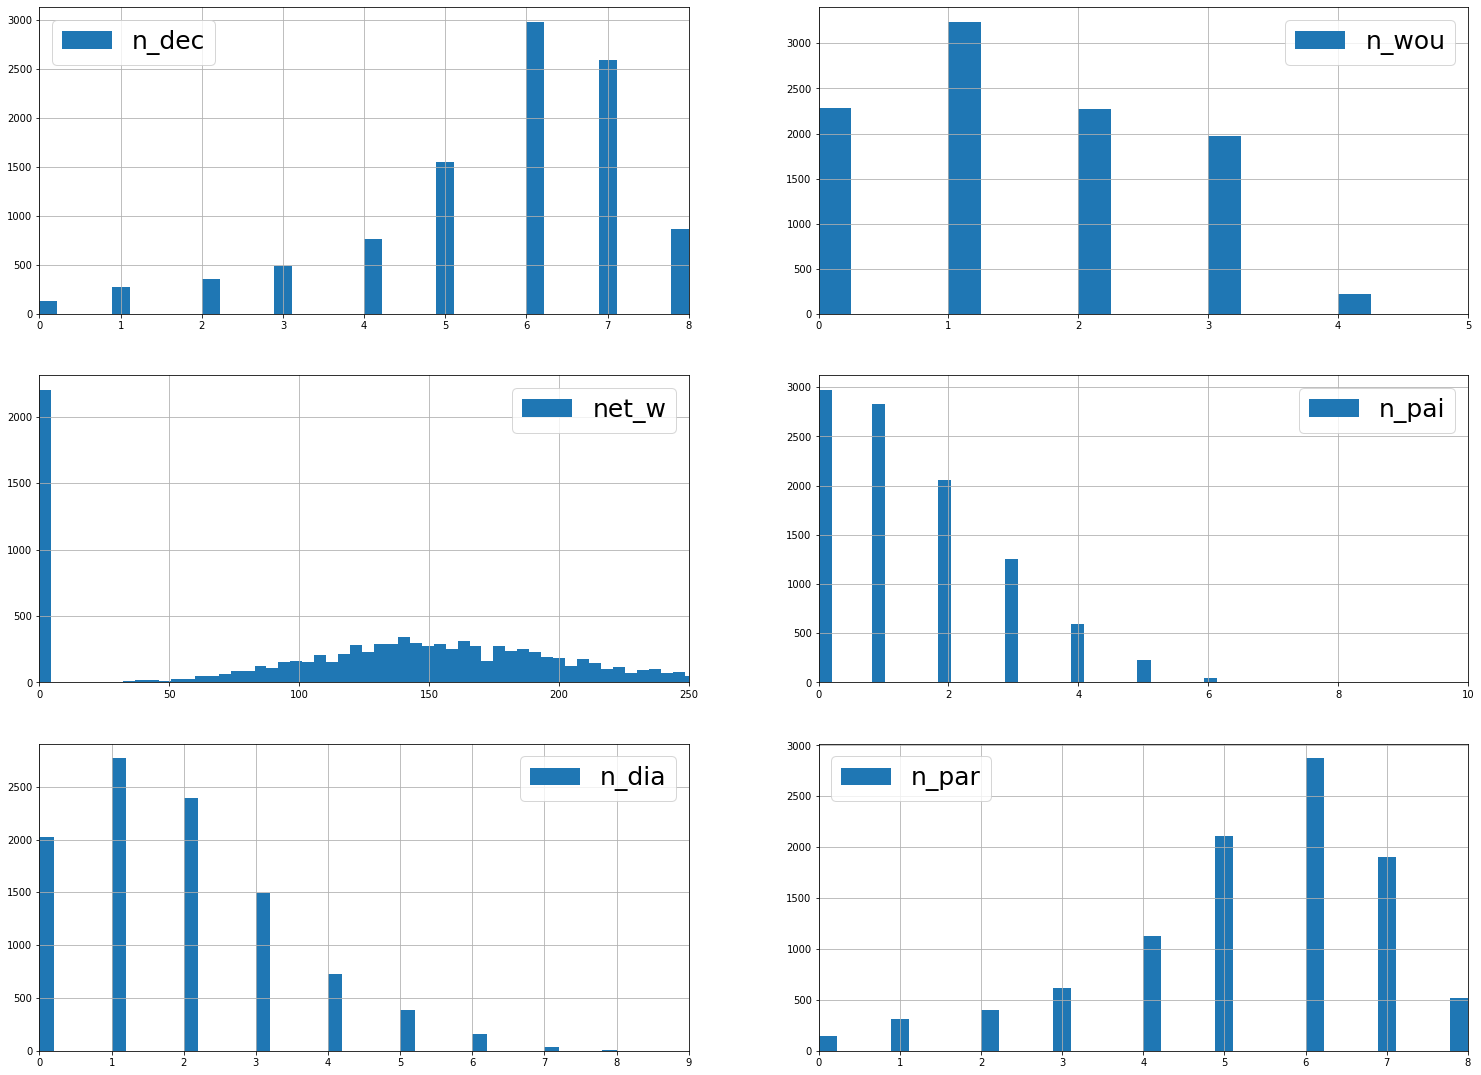

In [ ]:
s = 4
plt.figure(figsize = (6.4 * s, 4.8 * s))
legends = True

####################################################################################################

plt.subplot(3, 2, 1)
ax_n_dec = df_h.n_dec.hist(bins = 9 * 4, legend = legends)
ax_n_dec.set_xlim(0, 8)
ax_n_dec.legend(loc = 2, prop = { "size" : 25})

plt.subplot(3, 2, 2)
ax_n_wou = df_h.n_wou.hist(bins = 6 * 4, legend = legends)
ax_n_wou.set_xlim(0, 5)
ax_n_wou.legend(loc = 1, prop = { "size" : 25})

plt.subplot(3, 2, 3)
ax_net_w = df_h.net_w.hist(bins = 25 * 4, legend = legends)
ax_net_w.set_xlim(0, 250)
ax_net_w.legend(loc = 1, prop = { "size" : 25})

plt.subplot(3, 2, 4)
ax_n_pai = df_h.n_pai.hist(bins = 11 * 4, legend = legends)
ax_n_pai.set_xlim(0, 10)
ax_n_pai.legend(loc = 1, prop = { "size" : 25})

plt.subplot(3, 2, 5)
ax_n_dia = df_h.n_dia.hist(bins = 10 * 4, legend = legends)
ax_n_dia.set_xlim(0, 9)
ax_n_dia.legend(loc = 1, prop = { "size" : 25})

plt.subplot(3, 2, 6)
ax_n_par = df_h.n_par.hist(bins = 9 * 4, legend = legends)
ax_n_par.set_xlim(0, 8)
ax_n_par.legend(loc = 2, prop = { "size" : 25})